# Model Training

In this notebook we will train different models to predict the target variable `class`.

First we will load the data, split it into training and testing sets and balance the training set.

Then we will train the following models:

Simple models:

- Decision tree classifier
- Logistic regression
- K-nearest neighbors classifier
- Multilayer perceptron classifier

Ensemble models:

- Random forest classifier
- Gradient boosting classifier
- XGBoost

The models will be evaluated through:

- Accuracy
- ROC AUC
- F1 score
- Recall on poisonous class

The best 3 models will be selected and their hyperparameters will be optimized using grid search, bayesian optimization and a genetic algorithm.

Finally, we will save the best model and its hyperparameters and use it for deployment.

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn_genetic import GASearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

sns.set_style("darkgrid")
sns.set_palette("Set1")

In [5]:
df = pd.read_csv("../Data/WorkingData/train.csv")

In [6]:
filename = "../Models/Transformations/transformations.pkl"
minmax, labelEncoder = pickle.load(open(filename, "rb"))

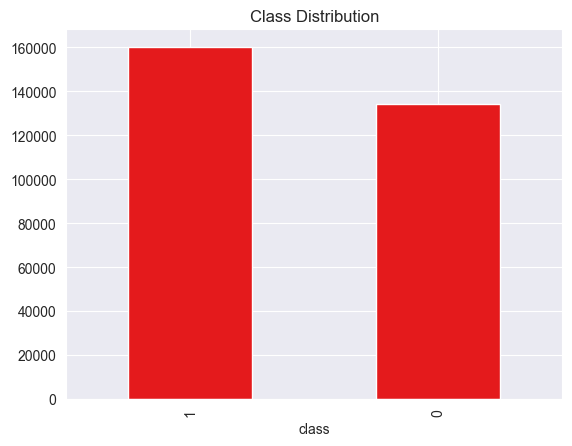

In [7]:
X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=13)
y_train.value_counts().plot(kind="bar", title="Class Distribution")
plt.show()

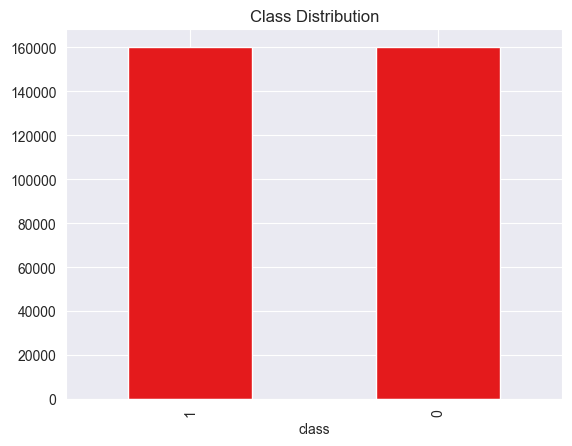

In [8]:
smote = SMOTE(sampling_strategy="auto", random_state=13)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts().plot(kind="bar", title="Class Distribution")
plt.show()

In [9]:
all_models = pd.DataFrame(index=["Accuracy", "ROC AUC", "F1 Score", "Recall Poisonous"])

### Decision Tree Classifier

In [10]:
model_dt = DecisionTreeClassifier(criterion="gini", min_samples_leaf=20, max_depth=5)
model_dt.fit(X_train, y_train)

Y_pred = model_dt.predict(X_test)
print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["Decision Tree"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.72      0.70      0.71     57394
           p       0.76      0.78      0.77     68606

    accuracy                           0.74    126000
   macro avg       0.74      0.74      0.74    126000
weighted avg       0.74      0.74      0.74    126000



### Logistic Regression

In [11]:
model_lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=500,
    random_state=42,
)
model_lr.fit(X_train, y_train)

Y_pred = model_lr.predict(X_test)
Y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["Logistic Regression"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred_proba),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.71      0.79      0.75     57394
           p       0.81      0.73      0.76     68606

    accuracy                           0.76    126000
   macro avg       0.76      0.76      0.76    126000
weighted avg       0.76      0.76      0.76    126000



### K-Nearest Neighbors Classifier

In [12]:
model_knn = KNeighborsClassifier(n_neighbors=2, metric="euclidean")
model_knn.fit(X_train, y_train)

Y_pred = model_knn.predict(X_test)
print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["KNN"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.96      0.99      0.98     57394
           p       0.99      0.97      0.98     68606

    accuracy                           0.98    126000
   macro avg       0.98      0.98      0.98    126000
weighted avg       0.98      0.98      0.98    126000



### Multilayer Perceptron Classifier

In [13]:
model_rn = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(25),
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.02,
    momentum=0.3,
    max_iter=500,
    verbose=False,
)
model_rn.fit(X_train, y_train)

Y_pred = model_rn.predict(X_test)
print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["NN"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.98      0.98      0.98     57394
           p       0.99      0.98      0.98     68606

    accuracy                           0.98    126000
   macro avg       0.98      0.98      0.98    126000
weighted avg       0.98      0.98      0.98    126000



### Gradient Boosting Classifier

### Random Forest Classifier

### XGBoost

### All models evaluation results

### Hypothesis testing for best models

## Hiperparameter optimization

### Grid Search

### Bayesian Optimization

### Genetic Algorithm Optimization

### Hiperparameter optimization results

### Model Selection